In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.cluster import KMeans

import skimage
from skimage.transform import resize
from skimage import io
from skimage.color import rgb2gray

from tensorflow.keras.applications.resnet50 import preprocess_input
import glob

In [2]:
# Showing some of the images in the dataset

# Taking all the images, resizing them to 96X96 and putting them in a list
directory = "/kaggle/input/randomanimaldata/dataset"

import cv2

Images = []

for image in os.listdir(directory):
#     img = mpimg.imread(directory + "/" + image)
#     Images.append(img)

# Using CV2
#     im = cv2.imread(directory + "/" + image)
#     im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
#     im = cv2.resize(im,(224,224))
    
# Using skimage
    img = io.imread(directory + '/' + image)
#     img = rgb2gray(img)
    img = resize(img,(96,96))
#     plt.imshow(im)
#     break
    Images.append(img)

    
# plt.figure(figsize = (15,15))

# for n in range(30):
#     ax = plt.subplot(6,5,n+1)
#     plt.imshow(Images[n])
#     plt.axis('off')
    

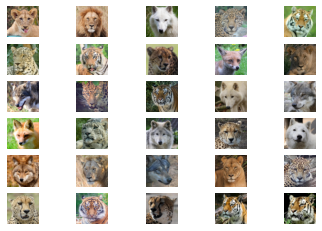

In [3]:
# Displaying some of the images
for n in range(30):
    ax = plt.subplot(6,5,n+1)
    plt.imshow(Images[n])
    plt.axis('off')

In [17]:
from tensorflow.keras import Sequential
resnet = tf.keras.applications.ResNet50(include_top = False, pooling = 'avg', weights='imagenet')
new_model = Sequential()
new_model.add(resnet)

new_model.layers[0].trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [36]:
# Summary of Resnet Model
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [37]:
# Summary of New Model
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [19]:
glob.glob(directory)

['/kaggle/input/randomanimaldata/dataset']

In [21]:
# Function to make Vectors for Images

# Resizing the Images to 224X224 and then using the tensorflow model to get a feature vector to use the KMeans clustering algorithm
def extract_vector(path):
    resnet_feature_list = []

    for i in os.listdir(path):
        im = directory + '/' + i
        im = cv2.imread(im)
        im = cv2.resize(im,(224,224))
        img = preprocess_input(np.expand_dims(im.copy(), axis=0))
        resnet_feature = new_model.predict(img)
        resnet_feature_np = np.array(resnet_feature)
        resnet_feature_list.append(resnet_feature_np.flatten())

    return np.array(resnet_feature_list)

In [22]:
# Making the Vectors
vectors = extract_vector(directory)

In [23]:
# As we can see, each vector is a numpy array of 2048 length
vectors.shape

(4738, 2048)

In [24]:
# Making an elbow curve to decide how many clusters to make
from sklearn.cluster import KMeans

# Making the elbow curve
K = range(5,20)

ssd = []
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(vectors)
    ssd.append(km.inertia_)

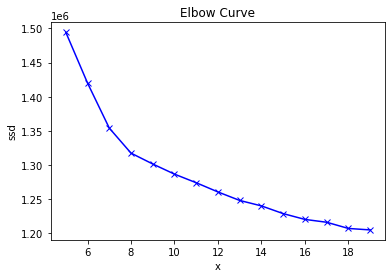

In [25]:
plt.plot(K,ssd, 'bx-')
plt.xlabel('x')
plt.ylabel('ssd')
plt.title('Elbow Curve')
plt.show()

*As we can see that the Elbow Curve stagnaters aroud 18 Clusters. By analysing the image data as well as the elbow curve, I chose 14 clusters to be an optimal number of clusters to group the animals.*

In [26]:
# Here we use 'k-means++' which means that while forming clusters, the initial 
# centroid will be as far away from each other as possible to get optimal datapoints in all clusters

km = KMeans(n_clusters = 14, init = 'k-means++')

km.fit(vectors)

labels = km.labels_


In [27]:
# Making a DataFrame with 2 columns, 'Name' and 'Label'
# Name = Name of the Image
# Label = No. of the Cluster
pred = pd.DataFrame()

pred['Name'] = os.listdir(directory)
pred['Label'] = labels


In [28]:
# Here we can see the distribution of all clusters
pred['Label'].value_counts()

4     573
1     544
13    417
10    402
6     384
5     378
11    357
0     354
12    328
8     289
9     267
2     200
7     162
3      83
Name: Label, dtype: int64

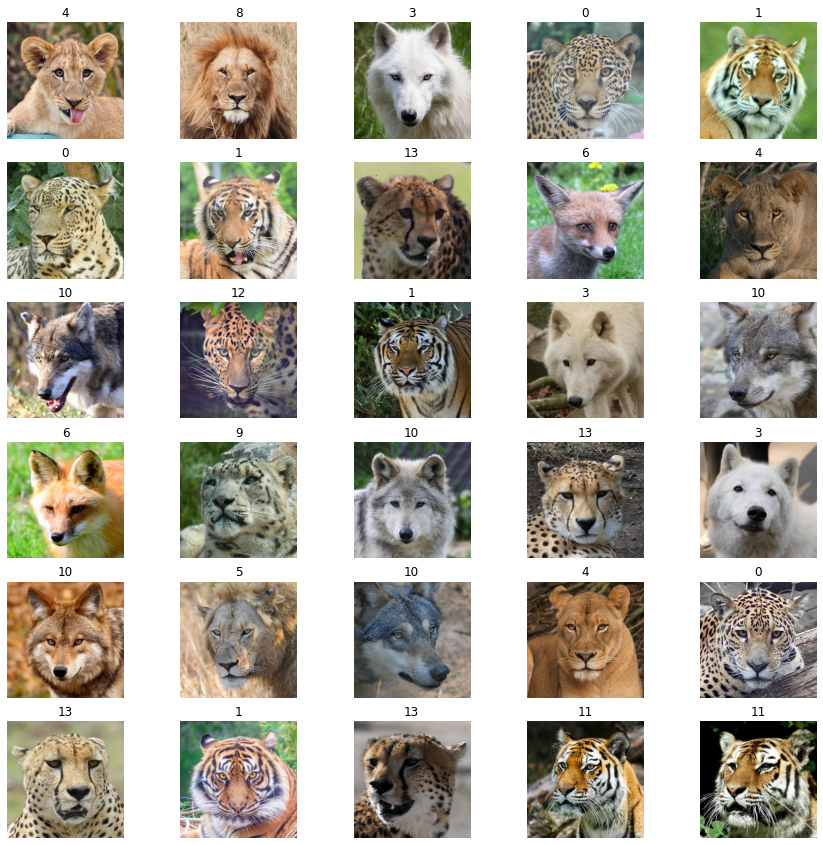

In [29]:
# Looking at the inages and the predicted clusters to see if the model works
plt.figure(figsize = (15,15))

for n in range(30):
    ax = plt.subplot(6,5,n+1)
    img = mpimg.imread(directory + '/' + pred['Name'][n])
    plt.imshow(img)
    plt.title(pred['Label'][n])
    plt.axis('off')
    

Since I can see that the KMeans model mapped similar animals in the same cluster, I will say this is a success.

In [30]:
# Downloading some files to check if the model generates similar images when given an input image
file_id_giraffe = '1X7OAIWC0_OJL9HPJCEsc6G9oWlSF2CLV'
file_id_leopard = "13-o-Cozo9yWFWWZd_CVt_Mk7bU4CXvnV"
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=13-o-Cozo9yWFWWZd_CVt_Mk7bU4CXvnV' -O SnowLeopard.jpg


--2020-08-18 16:37:18--  https://docs.google.com/uc?export=download&id=13-o-Cozo9yWFWWZd_CVt_Mk7bU4CXvnV
Resolving docs.google.com (docs.google.com)... 172.217.203.138, 172.217.203.100, 172.217.203.113, ...
Connecting to docs.google.com (docs.google.com)|172.217.203.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/voj5ieo7s1tf0ph76ap0attfjgo77dn0/1597768575000/00117071312215224791/*/13-o-Cozo9yWFWWZd_CVt_Mk7bU4CXvnV?e=download [following]
--2020-08-18 16:37:19--  https://doc-00-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/voj5ieo7s1tf0ph76ap0attfjgo77dn0/1597768575000/00117071312215224791/*/13-o-Cozo9yWFWWZd_CVt_Mk7bU4CXvnV?e=download
Resolving doc-00-08-docs.googleusercontent.com (doc-00-08-docs.googleusercontent.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connecting to doc-00-08-docs.googleusercontent.com (doc-00

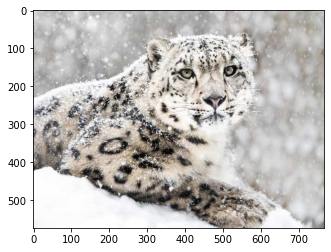

In [31]:
# This is a random file I generated which will be fed into the KMeans model to see if it will generate the appropriate cluster
file_dir = 'SnowLeopard.jpg'

img = mpimg.imread(file_dir)
plt.imshow(img)

In [32]:
# Finding Resnet feature Vector for input image
im = cv2.imread(file_dir)
im = cv2.resize(im,(224,224))
img = preprocess_input(np.expand_dims(im.copy(), axis=0))
resnet_feature = new_model.predict(img)
resnet_feature_np = np.array(resnet_feature)

In [33]:
resnet_feature_np.shape

(1, 2048)

In [34]:
# Predicting the cluster of the Input Image
km.predict(resnet_feature_np)

array([9], dtype=int32)

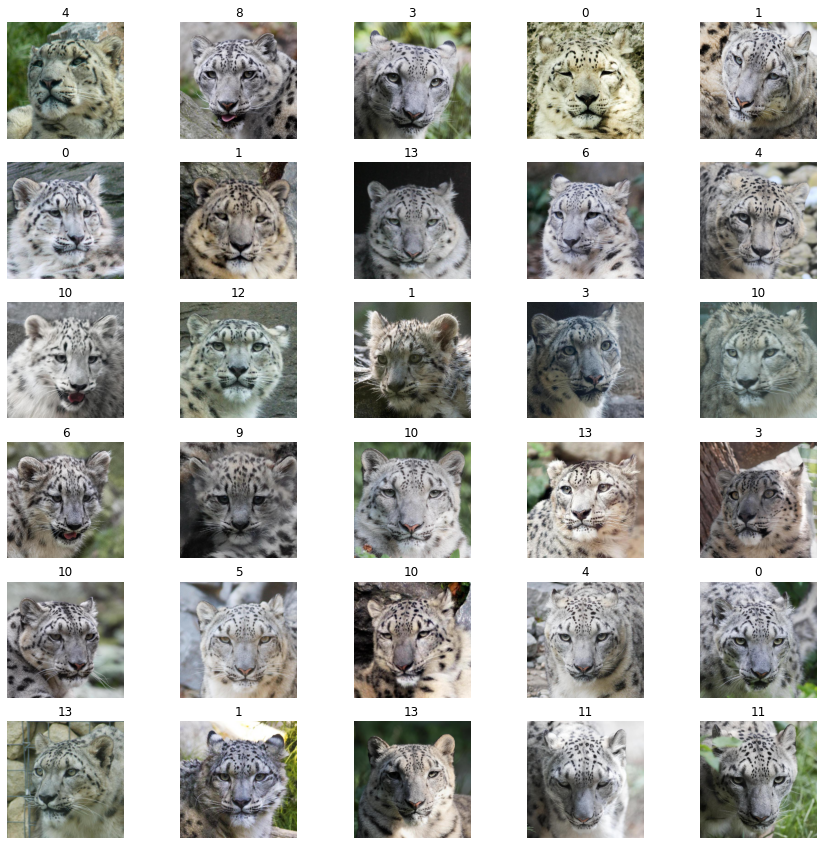

In [35]:
# Now I will plot some Images form the predicted cluster of the KMeans model to see if the Images in that cluster are similar or not

input_image_label = km.predict(resnet_feature_np)[0]

similar_images = pred[pred['Label'] == input_image_label]

# Let us plot
names = similar_images['Name'].values
plt.figure(figsize = (15,15))

for n in range(30):
    ax = plt.subplot(6,5,n+1)
    img = mpimg.imread(directory + '/' + names[n])
    plt.imshow(img)
    plt.title(pred['Label'][n])
    plt.axis('off')
    

We can see that the model accurately gives similar images to the one fed into it. I did indeed use a ResNet model and did not go for a custom Autoencoder model as, the final output is of KMeans and not of resnet. Also there was an issue of the memory consumption by the autoencoder model which was greater than the RAM of the Google Collab and Kaggle notebooks and I didn't have better hardware to make a bigger AutoEncoder model. I will be happy to work on an AutoEncoder model if given appropriate server.

Thank You